Import libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import requests
import re

Load and preprocess Data

In [ ]:
# URL for the text of "Alice's Adventures in Wonderland"
url = "https://www.gutenberg.org/files/11/11-0.txt"

response = requests.get(url)
if response.status_code == 200:
    text = response.text
    print("Dataset downloaded successfully!")
else:
    print("Error downloading dataset:", response.status_code)

# Quick inspection of the first few hundred characters
print(text[:500])

Dataset downloaded successfully!
*** START OF THE PROJECT GUTENBERG EBOOK 11 ***

[Illustration]




Alice’s Adventures in Wonderland

by Lewis Carroll

THE MILLENNIUM FULCRUM EDITION 3.0

Contents

 CHAPTER I.     Down the Rabbit-Hole
 CHAPTER II.    The Pool of Tears
 CHAPTER III.   A Caucus-Race and a Long Tale
 CHAPTER IV.    The Rabbit Sends in a Little Bill
 CHAPTER V.     Advice from a Caterpillar
 CHAPTER VI.    Pig and Pepper
 CHAPTER VII.   A Mad Tea-Party
 CHAPTER VIII.  The Queen’s Croquet-Grou


EDA

In [ ]:
# Removing Project Gutenberg header and footer
start_marker = r"\*\*\* START OF THIS PROJECT GUTENBERG EBOOK .* \*\*\*"
end_marker = r"\*\*\* END OF THIS PROJECT GUTENBERG EBOOK .* \*\*\*"
text = re.split(start_marker, text, flags=re.IGNORECASE)[-1]
text = re.split(end_marker, text, flags=re.IGNORECASE)[0]

# Converting text to lowercase and removing extra whitespace
text = text.lower().strip()

# Building vocabulary of unique characters
vocab = sorted(set(text))
vocab_size = len(vocab)
print("Unique characters:", vocab_size)

# Creating mappings between characters and indices
char_to_idx = {ch: i for i, ch in enumerate(vocab)}
idx_to_char = {i: ch for i, ch in enumerate(vocab)}

# Encoding the text into integers
encoded_text = np.array([char_to_idx[ch] for ch in text])

# Setting sequence length and generating training examples
seq_length = 100
inputs = []
targets = []

for i in range(len(encoded_text) - seq_length):
    inputs.append(encoded_text[i:i+seq_length])
    targets.append(encoded_text[i+1:i+seq_length+1])  # Shifting target by one

inputs = np.array(inputs)
targets = np.array(targets)

print("Input shape:", inputs.shape)
print("Target shape:", targets.shape)

Unique characters: 51
Input shape: (147978, 100)
Target shape: (147978, 100)


Define the LSTM Model


Set Hyperparameters and Initialize Model

In [ ]:
class CharLSTM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers):
        super(CharLSTM, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, dropout=0.5, batch_first=True)  # Using dropout for regularization
        self.fc = nn.Linear(hidden_size, vocab_size)
        if embed_size == hidden_size:
            self.fc.weight = self.embed.weight

    def forward(self, x, hidden):
        # Forward pass: embedding -> LSTM -> reshape -> linear
        x = self.embed(x)
        out, hidden = self.lstm(x, hidden)
        out = out.contiguous().view(-1, out.shape[2])
        out = self.fc(out)
        return out, hidden

    def init_hidden(self, batch_size):
        # Initializing hidden and cell states
        weight = next(self.parameters()).data
        hidden = (weight.new(num_layers, batch_size, hidden_size).zero_(),
                  weight.new(num_layers, batch_size, hidden_size).zero_())
        return hidden

# Hyperparameters
embed_size = 256  # Using weight tying
hidden_size = 256
num_layers = 2
learning_rate = 0.002
num_epochs = 50
batch_size = 256

# Model and optimizer setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CharLSTM(vocab_size, embed_size, hidden_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2)  # LR scheduler

Train and test dataset

Epoch [1/50], Loss: 1.9125
Epoch [2/50], Loss: 1.5796
Epoch [3/50], Loss: 1.4494
Epoch [4/50], Loss: 1.3664
Epoch [5/50], Loss: 1.3043
Epoch [6/50], Loss: 1.2551
Epoch [7/50], Loss: 1.2139
Epoch [8/50], Loss: 1.1780
Epoch [9/50], Loss: 1.1455
Epoch [10/50], Loss: 1.1164
Epoch [11/50], Loss: 1.0896
Epoch [12/50], Loss: 1.0680
Epoch [13/50], Loss: 1.0455
Epoch [14/50], Loss: 1.0250
Epoch [15/50], Loss: 1.0068
Epoch [16/50], Loss: 0.9908
Epoch [17/50], Loss: 0.9757
Epoch [18/50], Loss: 0.9615
Epoch [19/50], Loss: 0.9487
Epoch [20/50], Loss: 0.9375
Epoch [21/50], Loss: 0.9274
Epoch [22/50], Loss: 0.9179
Epoch [23/50], Loss: 0.9096
Epoch [24/50], Loss: 0.9001
Epoch [25/50], Loss: 0.8917
Epoch [26/50], Loss: 0.8844
Epoch [27/50], Loss: 0.8778
Epoch [28/50], Loss: 0.8716
Epoch [29/50], Loss: 0.8650
Epoch [30/50], Loss: 0.8593
Epoch [31/50], Loss: 0.8541
Epoch [32/50], Loss: 0.8478
Epoch [33/50], Loss: 0.8425
Epoch [34/50], Loss: 0.8381
Epoch [35/50], Loss: 0.8336
Epoch [36/50], Loss: 0.8287
E

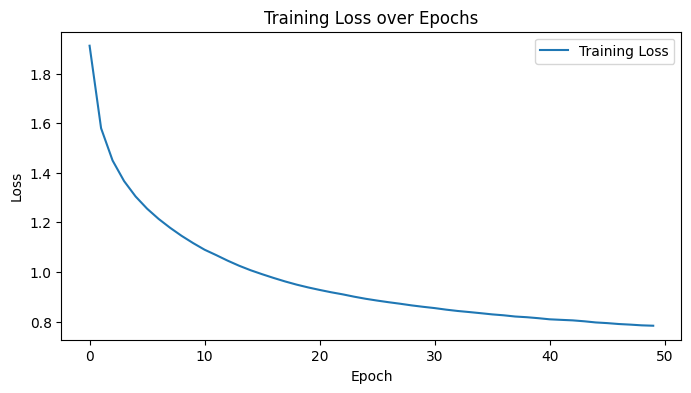

In [ ]:
# Getting batches
def get_batches(inputs, targets, batch_size):
    total_batches = len(inputs) // batch_size
    for i in range(0, total_batches * batch_size, batch_size):
        x = inputs[i:i+batch_size]
        y = targets[i:i+batch_size]
        yield torch.LongTensor(x), torch.LongTensor(y)

# Training loop
all_losses = []
model.train()
for epoch in range(num_epochs):
    hidden = model.init_hidden(batch_size)
    epoch_loss = 0.0
    batch_count = 0
    for x_batch, y_batch in get_batches(inputs, targets, batch_size):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        hidden = tuple(h.detach() for h in hidden)
        optimizer.zero_grad()
        outputs, hidden = model(x_batch, hidden)
        loss = criterion(outputs, y_batch.view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        optimizer.step()
        epoch_loss += loss.item()
        batch_count += 1
    avg_loss = epoch_loss / batch_count
    all_losses.append(avg_loss)
    scheduler.step(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(all_losses, label='Training Loss')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Evaluate the Model with test data

In [ ]:
def sample(model, start_str, length=200, temperature=1.0):
    model.eval()
    input_seq = torch.LongTensor([char_to_idx[ch] for ch in start_str]).unsqueeze(0).to(device)
    hidden = model.init_hidden(1)
    predicted = start_str

    for _ in range(length):
        output, hidden = model(input_seq, hidden)
        output = output[-1] / (temperature if temperature > 0 else 1.0)
        prob = torch.softmax(output, dim=0).data
        char_idx = torch.multinomial(prob, 1).item()
        predicted += idx_to_char[char_idx]
        input_seq = torch.LongTensor([[char_idx]]).to(device)
    return predicted

# Generate text starting with "alice"
seed = "alice"
generated_text = sample(model, seed, length=300, temperature=0.8)
print("Generated text:\n")
print(generated_text)

Generated text:

alice did not seem to be true_—’ that’s, you know—”

“come, ly, that they looked so, and shake out afterwards. only both make your evidence


“call him the day—”

“then the twinkling of the march hare had never fiels him teand, and she jumped up on their slates; “and must have this cheered, all
t
